In [1]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d
from uncertainties import ufloat


/home/dpirvu/.local/lib/python3.7/site-packages/


In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
nLat = 256
nTime = 256
nSims = 20000
simStep = nSims//10

lamb = 1.5; print('lamb = ', lamb)
phi0 = np.pi; print('phi0 = ', phi0)
nu = 2.*10**(-3)
m2eff = 4. * nu * (- 1. + lamb**2); print('m2eff = ', m2eff)
lenLat = 200. / np.sqrt(2. * nu); print('lenLat = ', lenLat)
phi_initial = 0.
V = lambda phi: 0.5 * m2eff * phi**2

nyq = nLat//2+1; spec = nyq; dx = lenLat/nLat; dk = 2.*np.pi/lenLat; print('dx, dk, spec ', dx, dk, spec)
alpha = 8.; dt = dx/alpha; dtout = dt*nLat/nTime; print('dtout/dt = ', dtout/dt)
light_cone = int(dtout/dx); print('light_cone = ', light_cone)

lamb =  1.5
phi0 =  3.141592653589793
m2eff =  0.01
lenLat =  3162.2776601683795
dx, dk, spec  12.352647110032732 0.0019869176531592202 129
dtout/dt =  1.0
light_cone =  0


### Theoretical Field PS 

In [4]:
paper_norm = 1./ phi0 / np.sqrt(2*lenLat)
spectral_field = lambda tem: paper_norm * np.sqrt(2./(np.exp(((np.fft.fftfreq(nLat, dx)*2*np.pi)**2 + m2eff)**0.5/tem) - 1.) + 1.) / ((np.fft.fftfreq(nLat, dx)*2*np.pi)**2 + m2eff)**0.25
Filter = lambda sigma: np.exp(-0.5* (np.fft.fftfreq(nLat, dx)*2*np.pi*dx*sigma)**2.)
pspec = lambda tem, sigma: np.abs(spectral_field(tem))**2. if sigma == 0. else np.abs(Filter(sigma) * spectral_field(tem))**2.
spacelike_pspec = lambda deltaR, tem, sigma: np.sum(pspec(tem, sigma) * np.cos(np.fft.fftfreq(nLat, dx)*2*np.pi*dx*deltaR))
timelike_pspec = lambda deltaT, tem, sigma: np.sum(pspec(tem, sigma) * np.cos(((np.fft.fftfreq(nLat, dx)*2*np.pi)**2 + m2eff)**0.5*dtout*deltaT))
sigma0_th = lambda tem, sigma: np.sqrt(np.sum(pspec(tem, sigma)))

### Extract data from files

In [5]:
sim_location = lambda nT, nL, tem, phi, lam, sim: '/gpfs/dpirvu/thermal_bubbles/free_t'+str(nT)+'_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
sim_suffix = lambda phi, lam, tem: '_for_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)

plots_file = '/home/dpirvu/thermal_bubbles/plots/'
pickle_file = '/home/dpirvu/pickle_location/thermal_bubbles/'
targets_file = lambda phi, lam, tem, filt, thresh: pickle_file+'targets'+sim_suffix(phi, lam, tem)+'_threshold{:.4f}'.format(thresh)+'_filter{:.4f}'.format(filt)+'.npy'
corr_file = lambda phi, lam, tem, filt, thresh: pickle_file+'correlator'+sim_suffix(phi, lam, tem)+'_threshold{:.4f}'.format(thresh)+'_filter{:.4f}'.format(filt)+'.npy'

In [6]:
smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma))

list_thresh = lambda temp, sigma: np.arange(1, 500)/100*sigma0_th(temp, sigma)

def extract_sim(nT, nL, tem, phi, lam, sim, sigma=0.):
    data = np.reshape(np.genfromtxt(sim_location(nT, nL, tem, phi, lam, sim)), (nT, nL))
    if sigma != 0:
        data = np.asarray([smoothen(slic, sigma) for slic in data])
    return data

def find_peak_positions(slice, threshold):
    """ Finds x coordinate of peaks in masked field with mask applied at threshold. """
    peak_coord = scs.find_peaks(slice, height = threshold)[0].tolist()
    if slice[-1] >= threshold and slice[0] >= threshold and slice[-1] != slice[0]:
        if slice[0] > slice[-1] and slice[0] > slice[1]:
            peak_coord.append(0)
        elif slice[0] < slice[-1] and slice[-1] > slice[-2]:
            peak_coord.append(len(slice)-1) # this minds potential boundary discontinuities
    return np.asarray(peak_coord)

round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

In [7]:
list_temp = np.arange(1,6)/10.
filter_size = 0.

In [8]:
all_data = np.asarray([[extract_sim(nTime, nLat, temp, phi0, lamb, sim, filter_size) for sim in range(nSims)] for temp in list_temp])

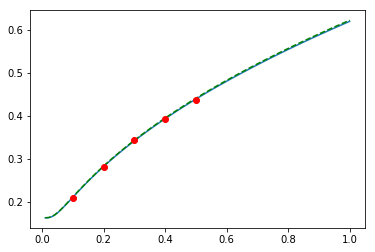

In [9]:
# Check field initialization
fromMM = [0.16328,0.163637,0.165625,0.169602,0.175116,0.18164,0.188773,0.19624,0.20386,0.211519,0.219144,0.226691,0.234133,0.241453,0.248644,0.255702,0.262626,0.269419,0.276084,0.282624,0.289043,0.295345,0.301536,0.30762,0.3136,0.319482,0.325269,0.330964,0.336572,0.342096,0.347539,0.352905,0.358195,0.363414,0.368564,0.373646,0.378665,0.383621,0.388516,0.393354,0.398136,0.402863,0.407538,0.412162,0.416736,0.421263,0.425743,0.430177,0.434568,0.438916,0.443223,0.44749,0.451717,0.455906,0.460058,0.464174,0.468254,0.4723,0.476312,0.480291,0.484239,0.488154,0.49204,0.495895,0.499722,0.503519,0.507289,0.511031,0.514747,0.518436,0.5221,0.525738,0.529352,0.532941,0.536507,0.54005,0.54357,0.547067,0.550543,0.553997,0.55743,0.560842,0.564233,0.567605,0.570957,0.574289,0.577602,0.580897,0.584173,0.587432,0.590672,0.593895,0.5971,0.600289,0.603461,0.606616,0.609756,0.612879,0.615986,0.619078]
plt.plot(np.arange(0.01, 1.01, 0.01), fromMM) # Mathematica
plt.plot(np.arange(0.01, 1.01, 0.01), [sigma0_th(temp, filter_size) for temp in np.arange(0.01, 1.01, 0.01)], 'g--') # Python
plt.plot(list_temp, np.asarray([np.mean([np.std(all_data[temp][sim][0]) for sim in range(len(all_data[temp]))]) for temp in range(len(list_temp))]), 'ro') # simulations
plt.savefig(plots_file+'sigma0_vs_temp.pdf')
plt.show()

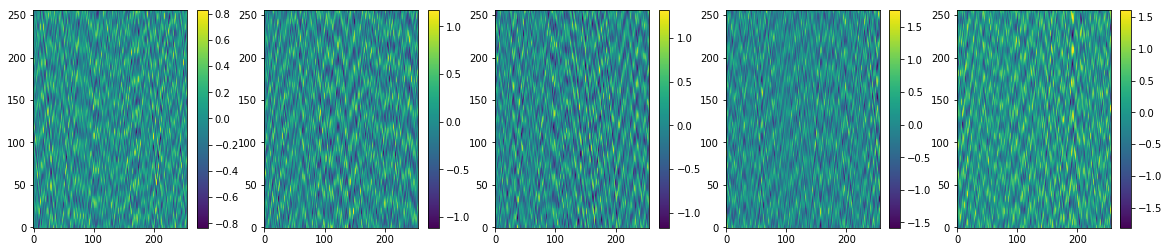

In [10]:
for sim in range(0, 50, 50):
    fig, ax = plt.subplots(1, len(list_temp), figsize = (4*len(list_temp), 4))
    for temp in range(len(list_temp)):
        im0 = ax[temp].imshow(all_data[temp][sim], aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im0, ax = ax[temp])
    plt.show()

In [11]:
ndpeaks = np.asarray([[np.mean([len(find_peak_positions(realisation[random.randrange(nTime)], th))/lenLat for realisation in all_data[temp]]) for th in list_thresh(list_temp[temp], filter_size)] for temp in range(len(list_temp))])

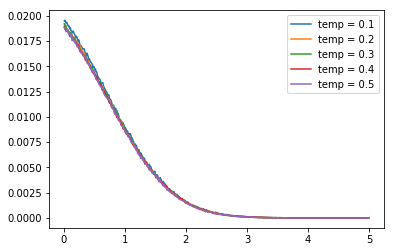

In [12]:
[plt.plot(list_thresh(list_temp[temp], filter_size)/sigma0_th(list_temp[temp], filter_size), ndpeaks[temp], label='temp = '+str(list_temp[temp])) for temp in range(len(list_temp))]
plt.legend()
plt.savefig(plots_file+'peak_number_density_vs_threshold.pdf')
plt.show()

In [13]:
temp = 0.1
list_timeslice = np.arange(0, nTime, nTime//4)
ndpeaks = np.asarray([[np.mean([len(find_peak_positions(realisation[timeslice], th))/lenLat for realisation in all_data[np.where(list_temp==temp)[0][0]]]) for th in list_thresh(temp, filter_size)] for timeslice in list_timeslice])

NameError: name 'all_data' is not defined

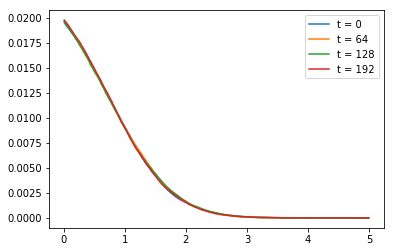

In [14]:
[plt.plot(list_thresh(temp, filter_size)/sigma0_th(temp, filter_size), ndpeaks[timeslice], label='t = '+str(list_timeslice[timeslice])) for timeslice in range(len(list_timeslice))]
plt.legend()
plt.savefig(plots_file+'peak_number_density_vs_threshold2.pdf')
plt.show()

### Spacelike Correlation Function

In [8]:
#Spacelike correlator from simulation real space data '_fields.dat'
def space_difference_amplitude(realisation, R, sigma):
    T, N = realisation.shape
    timeslice = random.randrange(T)
    x = random.randrange(N)
    field = realisation[timeslice]
    return 0.5*(field[x]*field[(x+R)%N]+field[x]*field[(x-R)%N])

#Average over simulations at fixed separation R
def sim_average_of_space_difference_amp(fulldata, R, sigma):
    return np.mean([space_difference_amplitude(realisation, R, sigma) for realisation in fulldata])

#Timelike correlator from simulation real space data '_fields.dat'
def time_difference_amplitude(realisation, deltat, sigma):
    T, N = realisation.shape
    spaceslice = random.randrange(N)
    exit = False
    while not exit:
        t = random.randrange(T-deltat)
        field = [realisation[i][spaceslice] for i in range(T)]
        if t+deltat < T and t-deltat >= 0:
            out = 0.5*(field[t]*field[t+deltat]+field[t]*field[t-deltat])
            exit = True
        elif t+deltat < T and t-deltat < 0:
            out = field[t]*field[t+deltat]
            exit = True
        elif t+deltat >= T and t-deltat >= 0:
            out = field[t]*field[t-deltat]
            exit = True
    return out

#Average over simulations at fixed time separation deltat
def sim_average_of_time_difference_amp(fulldata, deltat, sigma):
    return np.mean([time_difference_amplitude(realisation, deltat, sigma) for realisation in fulldata])

In [9]:
def plot_spacelike_correlator(fulldata, sigma, max):
    """Plots autocorrelation function at all distances, averaged in time."""
    fig, ax = plt.subplots(1, 1, figsize=(7,5))
    ax.set_ylabel(r'$\left< \phi(x^0=0, x^1) \phi(y^0=0, y^1) \right>$')
    ax.set_xlabel(r'$r = |x^1-y^1|$')
    colors = cycle(('b','g','orange','r','m','k'))
    for temp in range(len(fulldata)):
        col = next(colors)
        rspec_data = [sim_average_of_space_difference_amp(fulldata[temp], R, sigma) for R in range(1, max)]
        ax.plot(np.arange(1, max)*dx, rspec_data, label='T = '+str(list_temp[temp]), linestyle='None', marker='o', color=col, ms=2)
        th = [spacelike_pspec(R, list_temp[temp], sigma) for R in range(1, max)]
        ax.plot(np.arange(1, max)*dx, th, linestyle='-', color=col)
    plt.legend()
    plt.savefig(plots_file+'spacelike_correlator.pdf')
    plt.show()
    return

def plot_timelike_correlator(fulldata, sigma):
    """Plots autocorrelation function at all time intervals, averaged over lattice and simulations."""
    fig, ax = plt.subplots(1, 1, figsize=(7,5))
    ax.set_ylabel(r'$\left< \phi(t, x^1=x) \phi(t^{\prime}, y^1=x) \right>$')
    ax.set_xlabel(r'$\Delta t = |t-t^{\prime}|$')
    colors = cycle(('b','g','orange','r','m','k'))
    for temp in range(len(fulldata)):
        col = next(colors)
        rspec_data = [sim_average_of_time_difference_amp(fulldata[temp], deltat, sigma) for deltat in range(1, nTime-1)]
        ax.plot(np.arange(1, nTime-1)*dtout, rspec_data, label='T = '+str(list_temp[temp]), linestyle='None', marker='o', color=col, ms=2)
        th = [timelike_pspec(deltat, list_temp[temp], sigma) for deltat in range(1, nTime-1)]
        ax.plot(np.arange(1, nTime-1)*dtout, th, linestyle='-', color=col)
    plt.legend()
    plt.savefig(plots_file+'timelike_correlator.pdf')
    plt.show()
    return

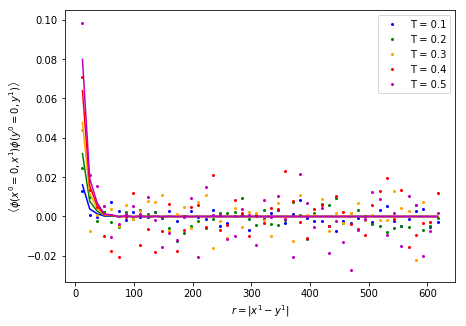

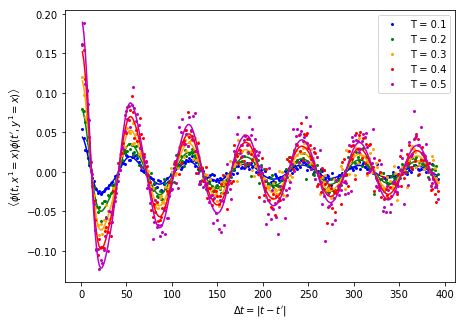

In [17]:
plot_spacelike_correlator(all_data, filter_size, nLat//5)
plot_timelike_correlator(all_data, filter_size)

### Mass Check 

In [8]:
omega = lambda k, m: k + m

multiplier = 3
masses = []
for temp in range(len(list_temp)):
    masses.append([])
    for sim in range(nSims):
        simulation = all_data[temp][sim]
        T, N = simulation.shape

        pspec_sim = np.abs(np.fft.fftshift(np.fft.fft2(simulation)))**2.
        kk = np.fft.fftshift(np.fft.fftfreq(N,d=dx))*2*np.pi
        oo = np.fft.fftshift(np.fft.fftfreq(T,d=dtout))*2*np.pi

        maxVal = np.mean(pspec_sim) + multiplier*np.std(pspec_sim)
        osccoords = np.argwhere(pspec_sim > maxVal)
        popt, pcov = sco.curve_fit(omega, kk[osccoords[:,1]]**2., oo[osccoords[:,0]]**2.)
        masses[-1].append(popt[0])

#        fig, ax = plt.subplots(1, 1, figsize = (8, 4))
#        ax.plot(kk, np.sqrt(omega(kk**2,*popt)), label='m=%5.5f'%popt[-1])
#        im = ax.imshow(pspec_sim, aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
#        ax.set_title('Simulation '+str(sim))
#        plt.xlabel(r'$\bar{k}$'); plt.ylabel(r'$\bar{\omega_k}$')
#    #    plt.axvline(0, color='darkgray', ls='-.'); plt.axhline(0, color='darkgray', ls='-.')
#        plt.legend(); plt.show()

NameError: name 'all_data' is not defined

Text(0.5, 0, '$T$')

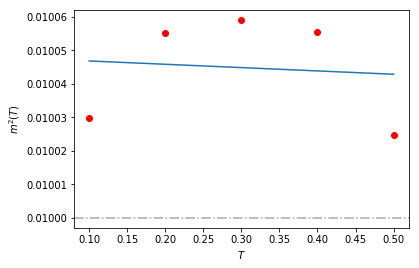

In [20]:
line_fit = lambda x, a, b: a * x + b
popt, _ = sco.curve_fit(line_fit, list_temp, np.mean(masses, axis=1))

plt.plot(list_temp, np.mean(masses, axis=1), 'ro')
plt.plot(list_temp, line_fit(list_temp, *popt), label='linear fit')
plt.axhline(m2eff, color='darkgray', ls='-.')
plt.ylabel(f'$m^2(T)$')
plt.xlabel(f'$T$')
plt.savefig(plots_file+'mass_distribution.pdf')

### Peak-Peak Correlation Function

In [10]:
def correlator(all_targets, R, RR):
    DCorrelator = []
    for sim in range(len(all_targets)):
        bubbleCoords = all_targets[sim]
        nBubbles = len(bubbleCoords)
        area = 2*np.abs(RR-R)
        bubNDens = nBubbles / nLat 
        bubCounter = 0.

        if nBubbles > 1:
            for bubloc in range(nBubbles):
                bdx = np.abs(bubbleCoords[bubloc] - bubbleCoords)
                bdx = [ww if ww < nLat//2 else nLat - ww for ww in bdx]
                bubCounter += len([l for l in bdx if R <= l < RR])
            DCorrelator.append( bubCounter / (bubNDens * area * nBubbles))
    return np.mean(DCorrelator) - 1.
    
def empirical_corr_and_err(all_targets, R, RR, simStep):
    simmer = np.arange(0, nSims, simStep)
    counter = [correlator(all_targets[simMin : simMax], R, RR) for simMin, simMax in zip(simmer, simmer[1:])]
    return np.mean(counter), stat.stdev(counter) / np.sqrt(len(counter))

def correlation_functions(all_targets, xrange, simStep):
    return np.asarray([empirical_corr_and_err(all_targets, R, RR, simStep) for R,RR in zip(xrange, xrange[1:])])

In [11]:
# Choose smoothing scale
filter_size = 0.

# Do you or do you not need to map all peaks
bool = False

# Detection threshold
list_threshold = np.asarray([sigma0_th(temp, filter_size)*np.asarray([0.5, 1., 1.5, 2.]) for temp in list_temp])

# Data binning
xmax = nLat//2
xstep = 1
xrange = np.arange(1, xmax, xstep)

In [12]:
if bool:
    for temp in range(len(list_temp)):
        all_data = np.asarray([extract_sim(nTime, nLat, list_temp[temp], phi0, lamb, sim, filter_size)[random.randrange(nTime)] for sim in range(nSims)])

        for threshold in list_threshold[temp]:
            all_targets = [find_peak_positions(realisation, threshold) for realisation in all_data]
            np.save(targets_file(phi0, lamb, list_temp[temp], filter_size, threshold/sigma0_th(list_temp[temp], filter_size)), all_targets)
            print('Done')

        del all_data

In [13]:
if bool:
    for temp in range(len(list_temp)):
        for threshold in list_threshold[temp][:2]:
            all_targets = np.load(targets_file(phi0, lamb, list_temp[temp], filter_size, threshold/sigma0_th(list_temp[temp], filter_size)))
            corr_data = correlation_functions(all_targets, xrange, simStep)
            np.save(corr_file(phi0, lamb, list_temp[temp], filter_size, threshold/sigma0_th(list_temp[temp], filter_size)), corr_data)
            print('Done')

In [14]:
tableau1 = [(50, 162, 81), (172,217,141), (255,127,15), (255,185,119), (60,183,204), (152,217,228), (184,90,13), (255,217,74), (57,115,124), (134,180,169), (130,133,59), (204,201,77)]
for i in range(len(tableau1)):
    r, g, b = tableau1[i]
    tableau1[i] = (r / 255., g / 255., b / 255.)

def plot_peak_correlators(xrange, temp, filter_size):
    list_threshold = np.asarray([0.5, 1.])#, 1.5, 2.])
    mark = ['o', 'D', 's', '^', 'v', '*']
    tabl = tableau1[::]
    labels = [r'$\phi_{t} =$']*len(list_threshold)
    xlist = xrange[:-1]#/filter_size
    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    for jjj, threshold in enumerate(list_threshold):
#        prediction0 = np.load(thcorr_file(threshold, filter_size))[:xrange[-1]]
#        prediction0 = gaussian_filter1d(prediction0, sigma=fldflt)
#        xaxis = np.arange(min(xrange), max(xrange)+1)[:len(prediction0)]/filter_size
#        plt.plot(xaxis, prediction0, color=tabl[jjj], ls='--', linewidth='1', alpha=1)`

        correlator_data = np.load(corr_file(phi0, lamb, temp, filter_size, threshold))
        corr, errcorr = gaussian_filter1d(correlator_data[:,0], sigma=fldflt), correlator_data[:,1]
        markers, caps, bars = plt.errorbar(xlist, corr, yerr=errcorr, linestyle='None', color=tabl[jjj], marker=mark[jjj], ms=3, alpha=1, ecolor=tabl[jjj], elinewidth=4, label=labels[jjj]+str(threshold)+r' $\sigma_0$'+' T = '+str(temp))
#        ax.set_yscale('log')
        [bar.set_alpha(0.5) for bar in bars]
        [cap.set_alpha(0.5) for cap in caps]
    plt.xlim(0,50)
    plt.xlabel(r'$r/R_0$')
    plt.ylabel(r'$\xi_{pk}$')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.8, linestyle='-', linewidth=0.5)
    plt.savefig(plots_file+'free_peak_correlator.pdf')
    return

In [15]:
fldflt = 0.01

[None, None, None, None, None]

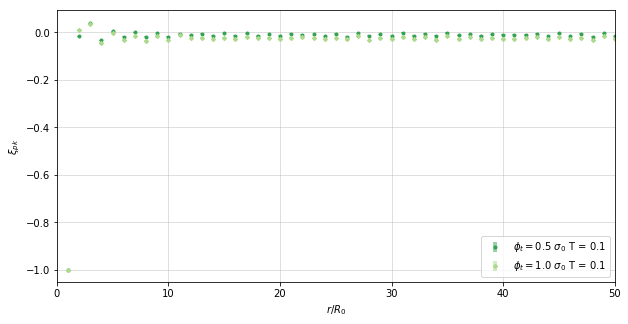

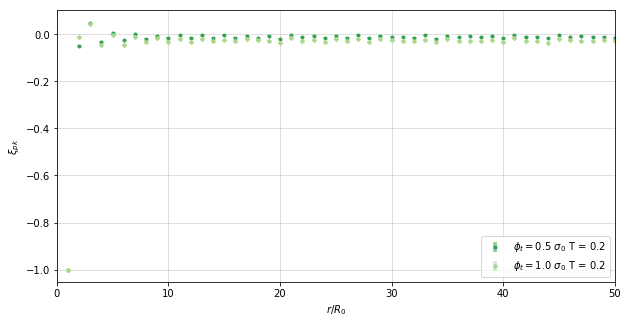

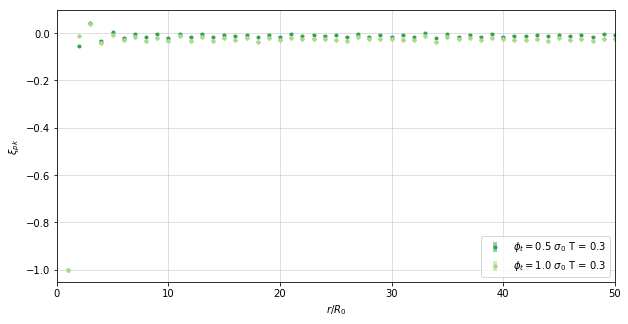

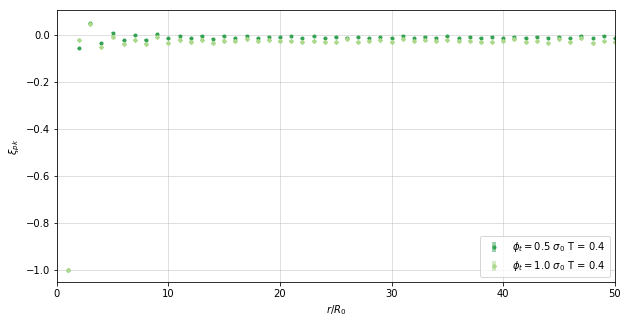

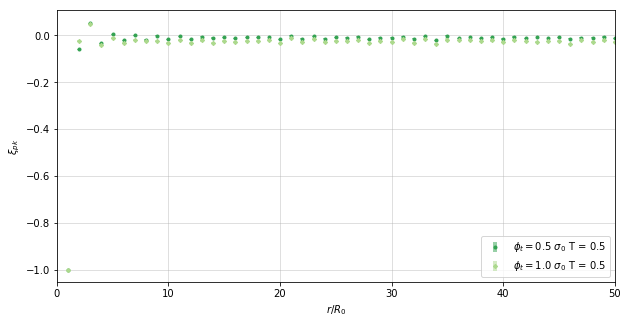

In [16]:
[plot_peak_correlators(xrange, tt, filter_size) for tt in list_temp]